In [342]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

import numpy as np
from keras import layers, models, optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

Downsampling the frequency domain from 65 to 8
(450, 67, 67, 8)
[ 0  8 16 24 32 41 49 57 65]
processing frequencies: 0 8
processing frequencies: 8 16
processing frequencies: 16 24
processing frequencies: 24 32
processing frequencies: 32 41
processing frequencies: 41 49
processing frequencies: 49 57
processing frequencies: 57 65
(450, 67, 67, 8)
Downsampled Frequency Domain shape (450, 67, 67, 8)
(450, 15, 15, 8)
Resized shape (450, 15, 15, 8)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Original data type: float64
y_test.shape before (225, 1)
y_test.shape after (225, 2)
Normalized data type: float16
Prepped test input shape (225, 15, 15, 8) Noralized MEAN: 0.06168 min -0.4036 max 7.285
Prepped train input shape (225, 15, 15, 8) Normalized MEAN: 0.0566 min -0.2627 max 2.16
Prepped test labels shape (225, 2) Normalized MEAN: 0.5 min 0.0 max 1.0
Prepped train labels shape (225, 2) Normalized MEAN: 0.5 min 0.0 max 1.0
EEG in dataset: (450, 15, 15, 8)
Labe

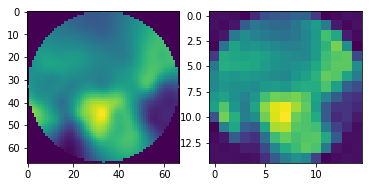

In [343]:
def group_frequency_bands(X):
    X_ = np.zeros([X.shape[0],X.shape[1],X.shape[2], 2])
#     X_[:,:,:,0] = np.mean(X[:,:,:,3:6],axis=3)
#     X_[:,:,:,1] = np.mean(X[:,:,:,7:11],axis=3)
#     X_[:,:,:,2] = np.mean(X[:,:,:,12:29],axis=3)
    
#     processing frequencies: 0 16
#     processing frequencies: 16 32
#     processing frequencies: 32 49
#     processing frequencies: 49 65
#     X_[:,:,:,0] = np.mean(X[:,:,:,0:16],axis=3)
#     X_[:,:,:,1] = np.mean(X[:,:,:,16:32],axis=3)
    X_[:,:,:,0] = np.mean(X[:,:,:,32:49],axis=3)
    X_[:,:,:,1] = np.mean(X[:,:,:,49:65],axis=3)
    
    X_.shape
    # subplot(1,3,1)
    # imagesc(squeeze(mean(X(1,:,:,4:7), 4)))
    # title('Theta')

    # subplot(1,3,2)
    # imagesc(squeeze(mean(X(1,:,:,8:12), 4)))
    # title('Alpha')

    # subplot(1,3,3)
    # imagesc(squeeze(mean(X(1,:,:,13:30), 4)))
    # title('Beta')
    return X_

def im_resize(X_, height, width):
    
    if width>0 and height>0:
        X__ = np.zeros([X_.shape[0], height, width, X_.shape[3]])
        for i in range(X_.shape[0]):
                for j in range(X_.shape[3]):
                    im = Image.fromarray(X_[i,:,:,j])
                    X__[i,:,:,j] = im.resize((height, width), Image.ANTIALIAS)
        print (X__.shape)

        plt.subplot(121)
        plt.imshow(np.array(X_[200,:,:,1]))
        plt.subplot(122)
        plt.imshow(np.array(X__[200,:,:,1]))
    else:
        print('IMAGES NOT RESIZED')
    return X__

def downsample_frequency_domain(n_bins):
    print('Downsampling the frequency domain from', X.shape[3],'to', n_bins)
    xx = np.zeros([X.shape[0],X.shape[1],X.shape[2],n_bins])
    print(xx.shape)
    a = np.round(np.linspace(0,X.shape[3],n_bins+1))
    a = a.astype('uint8')
    print(a)
    for i in range(n_bins):
        xx[:,:,:,i] = np.mean(X[:,:,:,a[i]:a[i+1]], axis=3)   
        print('processing frequencies:', a[i], a[i+1])
    print(xx.shape)
    return xx

def parse_array(in_array):
    new_array = []
    for i in range(len(in_array)):
        if str(in_array[i]).find("left")>0:
            new_array.append("left")
        if str(in_array[i]).find("right")>0:
            new_array.append("right")
        if (str(in_array[i]).find("left")<0 and 
            str(in_array[i]).find("right")<0):
            print(i)
            new_array.append("unknown")
    return new_array

def find_right(Q, label):
    idx = []
    for i in range(len(Q)):
        if Q[i] == label:
            idx.append(i)
    return(idx)


# file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=2, win=2, TOPO, .mat' #0.78 (CapsNet_EEG)
# file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=2, TOPO, .mat' #2# #0.77
file = 'Merged456-1-94_ICA(-2,3ICs)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=2, win=2, TOPO, .mat' #1# #0.76 #0.79 (0.74 CapsNet)
# file = 'EEG_ICA(-123_ICs)+proc_AUD_101_192_Merged456.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=2, win=2, TOPO, .mat' # 0.60 (CapsNet_EEG)



# file = 'Merged123_1_64_ICA(-eyes)AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=1, TOPO, .mat' # 0.60 CapsNET_EEG
# file = 'Merged123_75_134_ICA(-eyes)AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=2, TOPO, .mat'
# file = 'Merged123-143-202_ICA(-Eyes)+AUDpreproc.mat, DS2=64Hz, FIR=1-30Hz, centnorm=1, step=1, win=2, TOPO, .mat' #0.56

SHUFFLE = False
TEST_TRAIN = 0.5
DS_FREQ = 1 #(0 1 2)
n_bins = 8
RESIZE = 1
width = 15
height = 15
SENSITIVITY = 0
knockouts = [0, 1, 2]

path = '/home/amplifier/home/DATASETS/' + file
mat_contents = sio.loadmat(path)
X = mat_contents['X']
Y = mat_contents['Z']
# Z = mat_contents['Z']
Q = parse_array(mat_contents['Q'])

if DS_FREQ==1:
    X = downsample_frequency_domain(n_bins)
    print('Downsampled Frequency Domain shape', X.shape)
if DS_FREQ==2:
    X = group_frequency_bands(X)
    print('Grouped Frequency Bands shape', X.shape)
if RESIZE==1:
    X = im_resize(X, height, width)
    print('Resized shape', X.shape)

if SENSITIVITY==1:
    X = np.delete(X, knockouts, axis=3)
    print('sens', X.shape)
if X.shape[1]<X.shape[2]:
    X = np.transpose(X,[0,2,1])

if Y.shape[1] > Y.shape[0]:
    Y = Y.T
    
# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
# Y = np.random.permutation(Y)

print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
x_train, x_test, y_train, y_test, q_train, q_test = train_test_split(X, Y, Q, test_size=TEST_TRAIN, shuffle=SHUFFLE)
print('Original data type:', x_train.dtype)


# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')
print('y_test.shape before', y_test.shape)


# one hot encode the labels:
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)
print('y_test.shape after', y_test.shape)

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

leng = X.shape[1] # if you work in the FD, this is the height of the sample time-frequency image, othewise EEG channels
chan = X.shape[2] # if you work in the FD, this is the width of the sample time-frequency image, othewise time samples of EEG signal

if len(X.shape)==3:
    streams = 1 # this is EEG channels if you work with frequency domain, in the TD streams = 1
if len(X.shape)==4:
    streams = X.shape[3] # this is EEG channels if you work with frequency domain, in the TD streams = 1

Y = Y.flatten()
print('Prepped test input shape', x_test.shape, "Normalized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('Prepped train input shape', x_train.shape, "Normalized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('Prepped test labels shape', y_test.shape, "Normalized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('Prepped train labels shape', y_train.shape, "Normalized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

# print('Window length', winsize)
# print('Step size:', stepsize)
# print('Trial length:', trial_len)

print('EEG in dataset:', X.shape)
print('Labels in dataset:', Y.shape)
print('Length of textual labels:', len(Q))

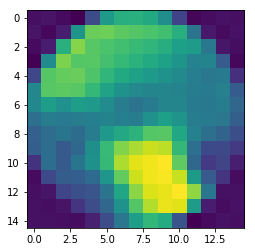

In [346]:
plt.imshow(x_train[1,:,:,1].astype('float32'))

In [351]:
TH = []
optim = []

In [352]:
input_shape = x_train[-1,:,:,:].shape
routings = 3
padding='same' # was 'valid' in the original code on github

n_class = 2

x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding=padding, activation='relu', name='conv1')(x)

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding=padding)


# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                         name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(digitcaps)

# Decoder network.
y = layers.Input(shape=(n_class,))
masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

# compile the model
train_model.compile(optimizer=optimizers.Adam(),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.392],
              metrics={'capsnet': 'accuracy'})

# train_model.compile(optimizer=optimizers.RMSprop(),
#               loss=[margin_loss, 'mse'],
#               loss_weights=[1., 0.392],
#               metrics={'capsnet': 'accuracy'})

# train_model.compile(optimizer=optimizers.Adadelta(),
#               loss=[margin_loss, 'mse'],
#               loss_weights=[1., 0.392],
#               metrics={'capsnet': 'accuracy'})

train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           (None, 15, 15, 8)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 256)  166144      input_72[0][0]                   
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 8, 8, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 2048, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [353]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler, Callback

EPOCHS = 100
init_lr = 0.00005
lr_drop_by = 0.995
drop_every = 5
BATCH_SIZE = 10

log = CSVLogger('/home/amplifier/home/NEW_DL/logs/CapsNET_log.csv')

checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/CapsNET.h5',
                               verbose=1,
                               monitor='val_capsnet_acc',
                               save_best_only=True)

K.set_value(train_model.optimizer.lr, init_lr)

def step_decay(epoch, init_lr=init_lr, lr_drop=lr_drop_by, drop_every=drop_every):
    if epoch%drop_every==0:
        lrate = init_lr * (lr_drop_by ** np.floor((1+epoch)/drop_every))
    else:
        lrate = K.get_value(train_model.optimizer.lr)
    print('CHECK', epoch%drop_every)
    return lrate

# def categorical_accuracy(y_true, y_pred):
#     return K.cast(K.equal(K.argmax(y_true, axis=-1),
#                           K.argmax(y_pred, axis=-1)),
#                           K.floatx())

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.batch_loss = []
        self.val_capsnet_acc = []
 
    def on_epoch_end(self, epoch, batch, logs={}):
        lrate = step_decay(epoch)
        txt = K.get_value(train_model.optimizer.lr)
        self.lr.append(txt)
#         self.lr.append(lrate)
#         txt = K.eval(self.model.optimizer.lr)
        print('OPTIMIZERS lrate AT EPOCH END = ', txt, '\n\n')
    
    def on_epoch_begin(self, epoch, batch, logs={}):
        txt = K.get_value(train_model.optimizer.lr)
        print('OPTIMIZERS lrate AT EPOCH START = ', txt)

    def on_batch_end(self, batch, logs={}):
        self.batch_loss.append(logs.get('loss'))
        

lr_decay = LearningRateScheduler(schedule=step_decay)
loss_history = LossHistory()

train_history = train_model.fit(
    [x_train, y_train],
    [y_train, x_train],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=[[x_test, y_test], [y_test, x_test]],
    callbacks=[log, checkpointer, lr_decay, loss_history]) # 

Train on 225 samples, validate on 225 samples
Epoch 1/100
CHECK 0
OPTIMIZERS lrate AT EPOCH START =  5e-05
225/225 [==============================] - 8s 37ms/step - loss: 0.8882 - capsnet_loss: 0.8100 - decoder_loss: 0.1994 - capsnet_acc: 0.4667 - val_loss: 0.8874 - val_capsnet_loss: 0.8086 - val_decoder_loss: 0.2010 - val_capsnet_acc: 0.4667

Epoch 00001: val_capsnet_acc improved from -inf to 0.46667, saving model to /home/amplifier/home/NEW_DL/weights/CapsNET.h5
CHECK 0
OPTIMIZERS lrate AT EPOCH END =  5e-05 


Epoch 2/100
CHECK 1
OPTIMIZERS lrate AT EPOCH START =  5e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.6256 - capsnet_loss: 0.5476 - decoder_loss: 0.1990 - capsnet_acc: 0.5333 - val_loss: 0.4084 - val_capsnet_loss: 0.3301 - val_decoder_loss: 0.1997 - val_capsnet_acc: 0.4667

Epoch 00002: val_capsnet_acc did not improve from 0.46667
CHECK 1
OPTIMIZERS lrate AT EPOCH END =  5e-05 


Epoch 3/100
CHECK 2
OPTIMIZERS lrate AT EPOCH START =  5e-05
225/225 [====

225/225 [==============================] - 1s 6ms/step - loss: 0.2111 - capsnet_loss: 0.2107 - decoder_loss: 0.0011 - capsnet_acc: 0.5556 - val_loss: 0.2242 - val_capsnet_loss: 0.2218 - val_decoder_loss: 0.0063 - val_capsnet_acc: 0.4578

Epoch 00020: val_capsnet_acc did not improve from 0.53778
CHECK 4
OPTIMIZERS lrate AT EPOCH END =  4.8518625e-05 


Epoch 21/100
CHECK 0
OPTIMIZERS lrate AT EPOCH START =  4.7555506e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.2166 - capsnet_loss: 0.2162 - decoder_loss: 0.0010 - capsnet_acc: 0.4978 - val_loss: 0.2286 - val_capsnet_loss: 0.2260 - val_decoder_loss: 0.0066 - val_capsnet_acc: 0.4622

Epoch 00021: val_capsnet_acc did not improve from 0.53778
CHECK 0
OPTIMIZERS lrate AT EPOCH END =  4.7555506e-05 


Epoch 22/100
CHECK 1
OPTIMIZERS lrate AT EPOCH START =  4.7555506e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.2104 - capsnet_loss: 0.2100 - decoder_loss: 9.4895e-04 - capsnet_acc: 0.5644 - val_loss


Epoch 00056: val_capsnet_acc did not improve from 0.64444
CHECK 0
OPTIMIZERS lrate AT EPOCH END =  3.5916448e-05 


Epoch 57/100
CHECK 1
OPTIMIZERS lrate AT EPOCH START =  3.5916448e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.1422 - capsnet_loss: 0.1418 - decoder_loss: 9.7962e-04 - capsnet_acc: 0.7511 - val_loss: 0.2443 - val_capsnet_loss: 0.2402 - val_decoder_loss: 0.0104 - val_capsnet_acc: 0.5867

Epoch 00057: val_capsnet_acc did not improve from 0.64444
CHECK 1
OPTIMIZERS lrate AT EPOCH END =  3.5916448e-05 


Epoch 58/100
CHECK 2
OPTIMIZERS lrate AT EPOCH START =  3.5916448e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.1462 - capsnet_loss: 0.1458 - decoder_loss: 9.9797e-04 - capsnet_acc: 0.7244 - val_loss: 0.2237 - val_capsnet_loss: 0.2202 - val_decoder_loss: 0.0088 - val_capsnet_acc: 0.6222

Epoch 00058: val_capsnet_acc did not improve from 0.64444
CHECK 2
OPTIMIZERS lrate AT EPOCH END =  3.5916448e-05 


Epoch 59/100
CHECK 3
OPTIMI

225/225 [==============================] - 1s 6ms/step - loss: 0.1262 - capsnet_loss: 0.1258 - decoder_loss: 8.6189e-04 - capsnet_acc: 0.7778 - val_loss: 0.2451 - val_capsnet_loss: 0.2412 - val_decoder_loss: 0.0099 - val_capsnet_acc: 0.6000

Epoch 00076: val_capsnet_acc did not improve from 0.64444
CHECK 0
OPTIMIZERS lrate AT EPOCH END =  2.7399316e-05 


Epoch 77/100
CHECK 1
OPTIMIZERS lrate AT EPOCH START =  2.7399316e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.1286 - capsnet_loss: 0.1283 - decoder_loss: 9.0742e-04 - capsnet_acc: 0.7689 - val_loss: 0.2386 - val_capsnet_loss: 0.2349 - val_decoder_loss: 0.0095 - val_capsnet_acc: 0.6089

Epoch 00077: val_capsnet_acc did not improve from 0.64444
CHECK 1
OPTIMIZERS lrate AT EPOCH END =  2.7399316e-05 


Epoch 78/100
CHECK 2
OPTIMIZERS lrate AT EPOCH START =  2.7399316e-05
225/225 [==============================] - 1s 6ms/step - loss: 0.1266 - capsnet_loss: 0.1262 - decoder_loss: 8.5639e-04 - capsnet_acc: 0.7867 - 

In [354]:
TH.append(train_history)
optim.append(train_model.optimizer.__class__.__name__)

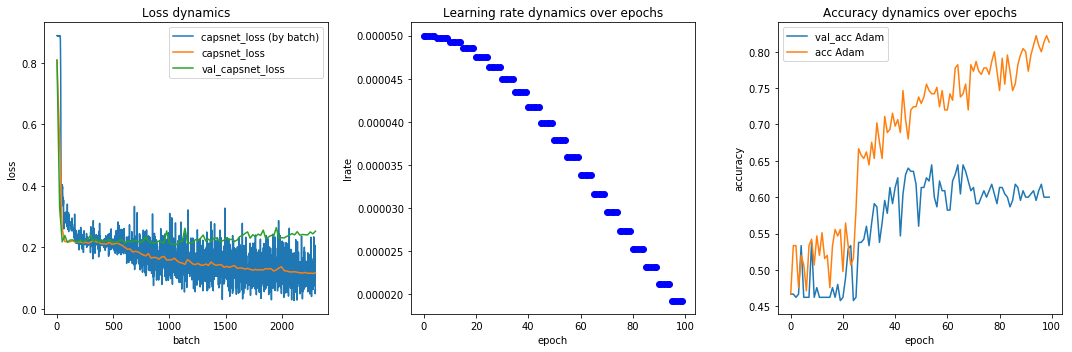

In [355]:
f, axs = plt.subplots(1,3,figsize=(15,5))
plt.subplot(131)
plt.plot(loss_history.batch_loss)
tic = np.linspace(0, len(loss_history.batch_loss), len(train_history.history['val_capsnet_loss']))
plt.plot(tic, train_history.history['capsnet_loss'])
plt.plot(tic, train_history.history['val_capsnet_loss'])
plt.title('Loss dynamics')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['capsnet_loss (by batch)', 'capsnet_loss', 'val_capsnet_loss'])

plt.subplot(132)
plt.plot(loss_history.lr,'bo')
plt.title('Learning rate dynamics over epochs')
plt.ylabel('lrate')
plt.xlabel('epoch')

asa = []
plt.subplot(133)
for i in range(len(TH)):
    plt.plot(TH[i].history['val_capsnet_acc'])
    plt.plot(TH[i].history['capsnet_acc'])
    asa.append('val_acc ' + optim[i])
    asa.append('acc ' + optim[i])
plt.title('Accuracy dynamics over epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(asa)

plt.tight_layout()

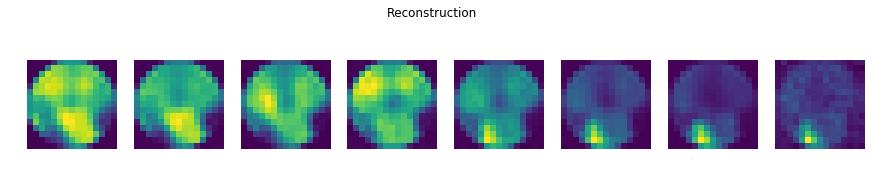

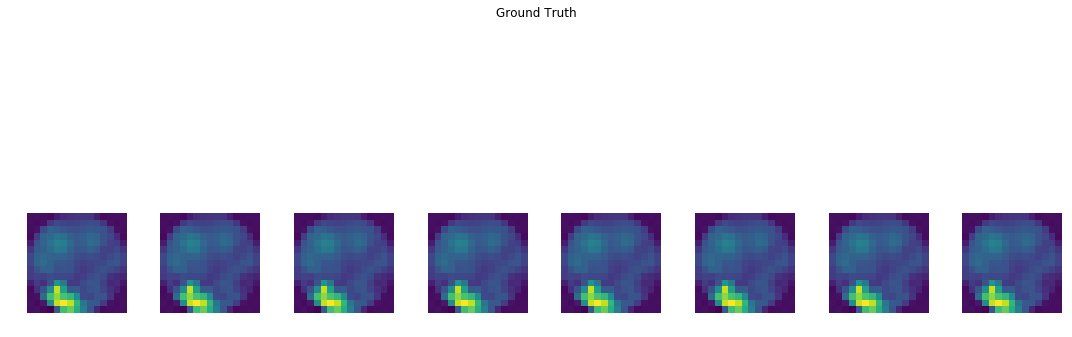

In [356]:
sample = 77
y_pred, x_recon = train_model.predict([x_test[None,sample,:,:,:], y_train[None,sample,:]])

yyy = x_train.shape[3]
f, axs = plt.subplots(1,yyy,figsize=(15,5))
for i in range(yyy):
    plt.subplot(2,yyy,i+1)
    plt.axis('off')
    plt.imshow(x_recon[-1,:,:,i].astype('float32'))
plt.suptitle('Reconstruction')
f, axs = plt.subplots(1,yyy,figsize=(15,5))
for i in range(yyy):
    plt.subplot(2,yyy,i+yyy+1)
    plt.imshow(x_test[1,:,:,-1].astype('float32'))
    plt.axis('off')
plt.suptitle('Ground Truth')
plt.tight_layout()


In [357]:
def hardmax(x):
    out = np.zeros([1,2])
    out = out.flatten()
    x = x.flatten()
    idx = np.argmax(x)
    out[idx] = 1
    return out

In [393]:
# load best weights:
train_model.load_weights('/home/amplifier/home/NEW_DL/weights/CapsNET.h5')

# ANOTHER TEST OF ACCURACY:

en = x_test.shape[0]-1

# this is to generate some random 0-1/1-0 pairs (the model wants a second input which can be anything)
dummy = np.random.rand(*y_test[0:en,:].shape)
for i in range(len(dummy)):
    dummy[i,:] = hardmax(dummy[i,:])  

In [394]:
y_pred, _ = train_model.predict([x_test[0:en,:,:,:], dummy])

suc_res = []
for i in range(len(y_pred)):
    if np.sum(np.abs(hardmax(y_pred[i,:]) - hardmax(y_test[i,:]))) == 0:
        result = 'success'
        suc_res.append(1)
    else:
        result = 'FAIL'
        suc_res.append(0)
    print(i, y_pred[i,:], y_test[i,:], result, sep=' ')
print(np.mean(suc_res))

0 [0.7932164  0.32855195] [1. 0.] success
1 [0.05793062 0.8810391 ] [1. 0.] FAIL
2 [0.7386315 0.5255373] [1. 0.] success
3 [0.7417234  0.61323404] [1. 0.] success
4 [0.5460541 0.7972549] [1. 0.] FAIL
5 [0.49253252 0.69452   ] [1. 0.] FAIL
6 [0.40856186 0.7733676 ] [1. 0.] FAIL
7 [0.67605835 0.517346  ] [1. 0.] success
8 [0.7704123 0.5663633] [1. 0.] success
9 [0.81473285 0.39458212] [1. 0.] success
10 [0.40956116 0.799728  ] [1. 0.] FAIL
11 [0.6312616  0.63452846] [1. 0.] FAIL
12 [0.78678256 0.44870025] [1. 0.] success
13 [0.7114284  0.47886673] [1. 0.] success
14 [0.6318237  0.67326057] [1. 0.] FAIL
15 [0.45562786 0.7613277 ] [0. 1.] success
16 [0.4930247  0.75939286] [0. 1.] success
17 [0.83637697 0.08403992] [0. 1.] FAIL
18 [0.79716176 0.42272136] [0. 1.] FAIL
19 [0.617871   0.63864154] [0. 1.] success
20 [0.49767256 0.6761486 ] [0. 1.] success
21 [0.21271105 0.8472753 ] [0. 1.] success
22 [0.51618415 0.7282426 ] [0. 1.] success
23 [0.09733184 0.8625068 ] [0. 1.] success
24 [0.24909

In [360]:
# ===========================================================
# SENSITIVITY ANALYSIS
# ===========================================================

# now let's tamper with layer 1 weights to see how it affects accuracy:

In [361]:
clean_wts = train_model.layers[1].get_weights()
alt_wts = clean_wts
print('Weights shape:', alt_wts[0].shape)
print('Biases shape:', alt_wts[1].shape)

Weights shape: (9, 9, 8, 256)
Biases shape: (256,)


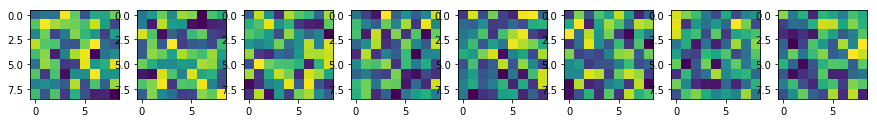

In [362]:
f, axs = plt.subplots(1,yyy,figsize=(15,5))

# restore weights to the learned ones at the start of each iteration:
train_model.layers[1].set_weights(clean_wts)
alt_wts = clean_wts

# # but zero out one filter:
# alt_wts[0][:,:,i,j] = np.zeros([9,9]).astype('float32')
# train_model.layers[1].set_weights(alt_wts)

for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(alt_wts[0][:,:,i,6])

In [391]:
from IPython.display import clear_output

result_mat = np.zeros([alt_wts[0].shape[2],alt_wts[0].shape[3]])

for i in range(alt_wts[0].shape[2]):
    for j in range(alt_wts[0].shape[3]):
        
        # restore weights to the learned ones at the start of each iteration:
        train_model.layers[1].set_weights(clean_wts)
        alt_wts = clean_wts
        
        # but zero out one filter:
        alt_wts[0][:,:,i,j] = np.zeros([9,9]).astype('float32')
        train_model.layers[1].set_weights(alt_wts)
        
#         print('checkpoint_', i, '_', j)
        y_pred, _ = train_model.predict([x_test[0:en,:,:,:], dummy])

        suc_res = []
        for k in range(len(y_pred)):
            if np.sum(np.abs(hardmax(y_pred[k,:]) - hardmax(y_test[k,:]))) == 0:
                result = 'success'
                suc_res.append(1)
            else:
                result = 'FAIL'
                suc_res.append(0)
#             print(i, y_pred[i,:], y_test[i,:], result, sep=' ')
        clear_output(wait=True)
        print(np.mean(suc_res), '\t', i,'\t', j, end="", flush=True)
        
        result_mat[i,j] = np.mean(suc_res)

0.46875 	 7 	 255

Text(0.5,1,'val_acc - val_acc(-1 filt.)')

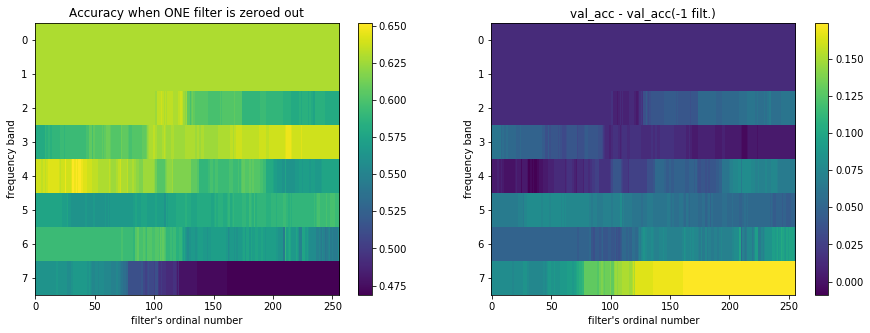

In [421]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

differ = np.mean(suc_res) - result_mat

img1 = axes[0].imshow(result_mat, interpolation='nearest')
axes[0].set_aspect('auto')
axes[0].set_xlabel('filter\'s ordinal number')
axes[0].set_ylabel('frequency band')
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].imshow(differ, interpolation='nearest')
axes[1].set_aspect('auto')
axes[1].set_xlabel('filter\'s ordinal number')
axes[1].set_ylabel('frequency band')
plt.colorbar(img2, ax=axes[1])
axes[0].set_title('Accuracy when ONE filter is zeroed out')
axes[1].set_title('val_acc - val_acc(-1 filt.)')



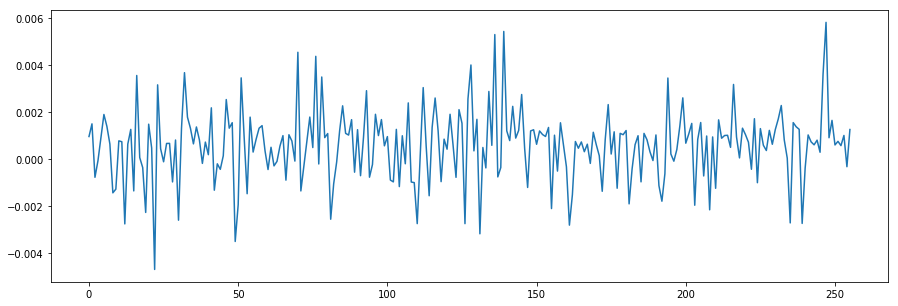

In [439]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
plt.plot(clean_wts[1])